In [213]:
# 导包
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [214]:
# 读取数据
# 根据题意，先把header设置好
headers = ['age', 'workclass', 'fnlwgt',
           'education', 'education_num', 'marital_status',
           'occupation', 'relationship', 'race',
           'sex', 'capital_gain', 'capital_loss',
           'hours_per_week', 'native_country', 'income']

# 读取训练集进入内存
train_data = pd.read_csv("data/adult_train.csv",names=headers)

# 对于测试集，他的第一行是一个分隔，不读入
test_data = pd.read_csv("data/adult_test.csv",names=headers,skiprows=[0])

In [215]:
# 看看训练集有多少数据
train_data.shape

(32561, 15)

In [216]:
# 看看数据是怎么样的，平均值；最大最小值，标准差等等（只有连续性的）
train_data.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [217]:
# 数据中有一些值是？，用python的NaN代替方便以后直接当作空值处理
train_data = train_data.replace('[?]', np.NaN, regex=True)
test_data = test_data.replace('[?]', np.NaN, regex=True)
# 看看数据里有NaN的各类有多少
train_data.isnull().sum()
test_data.isnull().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education_num       0
marital_status      0
occupation        966
relationship        0
race                0
sex                 0
capital_gain        0
capital_loss        0
hours_per_week      0
native_country    274
income              0
dtype: int64

In [218]:
# 对于缺失属性的数据直接删除
train_data = train_data.dropna()
train_data.isnull().sum()
test_data = test_data.dropna()
test_data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

In [219]:
# 开始处理离散数据
# income我们需要将其映射一下
# 先将>=50K的映射成0，<=50K的设置为1
income_map = {' <=50K':1,' >50K':0}
income_map2 = {' <=50K.':1, ' >50K.':0}
train_data['income'] = train_data['income'].map(income_map).astype(int)
test_data['income'] = test_data['income'].map(income_map2).astype(int)


In [220]:
# 取出所有的离散量属性
discrete = [x for x in train_data.columns if train_data[x].dtype=='object']
discrete

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

In [221]:
# 看看这些离散量属性的取值分布
for i in discrete:
    print(train_data[i].value_counts())
    

 Private             22286
 Self-emp-not-inc     2499
 Local-gov            2067
 State-gov            1279
 Self-emp-inc         1074
 Federal-gov           943
 Without-pay            14
Name: workclass, dtype: int64
 HS-grad         9840
 Some-college    6678
 Bachelors       5044
 Masters         1627
 Assoc-voc       1307
 11th            1048
 Assoc-acdm      1008
 10th             820
 7th-8th          557
 Prof-school      542
 9th              455
 12th             377
 Doctorate        375
 5th-6th          288
 1st-4th          151
 Preschool         45
Name: education, dtype: int64
 Married-civ-spouse       14065
 Never-married             9726
 Divorced                  4214
 Separated                  939
 Widowed                    827
 Married-spouse-absent      370
 Married-AF-spouse           21
Name: marital_status, dtype: int64
 Prof-specialty       4038
 Craft-repair         4030
 Exec-managerial      3992
 Adm-clerical         3721
 Sales                3584
 Othe

In [222]:
# 发现有一些是比较接近重叠的，将这些重叠的归到同一类
# 大致可以把gov有关的一类，Private一类，Self-emp一类，没工作的一类
train_data['workclass'] = train_data['workclass'].replace([' Self-emp-not-inc', ' Self-emp-inc'],' Self-emp')
train_data['workclass'] = train_data['workclass'].replace([' Federal-gov', ' Local-gov', ' State-gov'], ' Gov')
train_data['workclass'] = train_data['workclass'].replace([' Without-pay', ' Never-worked'], ' Un-emp')
train_data['workclass'].value_counts()                                                         

test_data['workclass'] = test_data['workclass'].replace([' Self-emp-not-inc', ' Self-emp-inc'],' Self-emp')
test_data['workclass'] = test_data['workclass'].replace([' Federal-gov', ' Local-gov', ' State-gov'], ' Gov')
test_data['workclass'] = test_data['workclass'].replace([' Without-pay', ' Never-worked'], ' Un-emp')

In [223]:
# 同理对marital_status进行归类
train_data['marital_status'] = train_data['marital_status'].replace([' Divorced',' Married-spouse-absent',' Never-married',' Separated',' Widowed'],' Single')
train_data['marital_status'] = train_data['marital_status'].replace([' Married-civ-spouse', ' Married-AF-spouse'], ' Couple')
train_data['marital_status'].value_counts()

test_data['marital_status'] = test_data['marital_status'].replace([' Divorced',' Married-spouse-absent',' Never-married',' Separated',' Widowed'],' Single')
test_data['marital_status'] = test_data['marital_status'].replace([' Married-civ-spouse', ' Married-AF-spouse'], ' Couple')

In [224]:
# native_country这个分类太多了，而且很多类的人很少，干脆把人少的都归到other里
train_data['native_country'] = train_data['native_country'].replace([' Holand-Netherlands',' Scotland', ' Honduras', 
                                                                     ' Hungary', ' Outlying-US(Guam-USVI-etc)', ' Yugoslavia', 
                                                                     ' Laos', ' Thailand', ' Cambodia', 
                                                                     ' Trinadad&Tobago', ' Hong', ' Ireland', 
                                                                     ' France',' Ecuador', ' Greece', ' Peru', 
                                                                     ' Nicaragua', ' Portugal', ' Iran', 
                                                                     ' Taiwan', ' Haiti'], ' Other')

test_data['native_country'] = test_data['native_country'].replace([' Holand-Netherlands',' Scotland', ' Honduras', 
                                                                     ' Hungary', ' Outlying-US(Guam-USVI-etc)', ' Yugoslavia', 
                                                                     ' Laos', ' Thailand', ' Cambodia', 
                                                                     ' Trinadad&Tobago', ' Hong', ' Ireland', 
                                                                     ' France',' Ecuador', ' Greece', ' Peru', 
                                                                     ' Nicaragua', ' Portugal', ' Iran', 
                                                                     ' Taiwan', ' Haiti'], ' Other')
train_data['native_country'].value_counts()

 United-States         27504
 Mexico                  610
 Other                   486
 Philippines             188
 Germany                 128
 Puerto-Rico             109
 Canada                  107
 India                   100
 El-Salvador             100
 Cuba                     92
 England                  86
 Jamaica                  80
 South                    71
 China                    68
 Italy                    68
 Dominican-Republic       67
 Vietnam                  64
 Guatemala                63
 Japan                    59
 Columbia                 56
 Poland                   56
Name: native_country, dtype: int64

In [225]:
# 最后，看看education_num这个连续量
train_data['education'].value_counts()

 HS-grad         9840
 Some-college    6678
 Bachelors       5044
 Masters         1627
 Assoc-voc       1307
 11th            1048
 Assoc-acdm      1008
 10th             820
 7th-8th          557
 Prof-school      542
 9th              455
 12th             377
 Doctorate        375
 5th-6th          288
 1st-4th          151
 Preschool         45
Name: education, dtype: int64

In [226]:
# 发现跟education一样的，重复了，因为eudcation是离散的，不好处理。去掉这个属性
train_data = train_data.drop(columns=['education'])
test_data = test_data.drop(columns=['education'])

In [227]:
# 看看相关系数矩阵,检查一下连续变量。发现序号属性不太影响最后的收入
train_data.corr()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income
age,1.000000,-0.076511,0.043526,0.080154,0.060165,0.101599,-0.241998
fnlwgt,-0.076511,1.000000,-0.044992,0.000422,-0.009750,-0.022886,0.008957
education_num,0.043526,-0.044992,1.000000,0.124416,0.079646,0.152522,-0.335286
capital_gain,0.080154,0.000422,0.124416,1.000000,-0.032229,0.080432,-0.221196
capital_loss,0.060165,-0.009750,0.079646,-0.032229,1.000000,0.052417,-0.150053
hours_per_week,0.101599,-0.022886,0.152522,0.080432,0.052417,1.000000,-0.229480
income,-0.241998,0.008957,-0.335286,-0.221196,-0.150053,-0.229480,1.000000


In [228]:
# 把序号属性删掉
train_data = train_data.drop(columns=['fnlwgt'])
test_data = test_data.drop(columns=['fnlwgt'])

In [229]:
# 进行one-hot编码
train_data = pd.get_dummies(train_data, columns=['workclass', 'marital_status', 'occupation',
                                                 'relationship', 'race', 'sex',
                                                 'native_country'])
train_data

test_data = pd.get_dummies(test_data, columns=['workclass', 'marital_status', 'occupation',
                                                 'relationship', 'race', 'sex',
                                                 'native_country'])

In [230]:
# 看看编码后的结果
train_data.columns

Index(['age', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'income', 'workclass_ Gov', 'workclass_ Private',
       'workclass_ Self-emp', 'workclass_ Un-emp', 'marital_status_ Couple',
       'marital_status_ Single', 'occupation_ Adm-clerical',
       'occupation_ Armed-Forces', 'occupation_ Craft-repair',
       'occupation_ Exec-managerial', 'occupation_ Farming-fishing',
       'occupation_ Handlers-cleaners', 'occupation_ Machine-op-inspct',
       'occupation_ Other-service', 'occupation_ Priv-house-serv',
       'occupation_ Prof-specialty', 'occupation_ Protective-serv',
       'occupation_ Sales', 'occupation_ Tech-support',
       'occupation_ Transport-moving', 'relationship_ Husband',
       'relationship_ Not-in-family', 'relationship_ Other-relative',
       'relationship_ Own-child', 'relationship_ Unmarried',
       'relationship_ Wife', 'race_ Amer-Indian-Eskimo',
       'race_ Asian-Pac-Islander', 'race_ Black', 'race_ Other', 'race_ Whit

In [231]:
# 将非2值类型的数据进行标准化
train_data_need_to_standard = train_data[['age', 'education_num', 'capital_gain',
                                          'capital_loss', 'hours_per_week']]
train_data_need_to_standard

,age,education_num,capital_gain,capital_loss,hours_per_week
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40
3,53,7,0,0,40
4,28,13,0,0,40
5,37,14,0,0,40
6,49,5,0,0,16
7,52,9,0,0,45
8,31,14,14084,0,50
9,42,13,5178,0,40


In [232]:
scaler = StandardScaler()
scaler.fit(train_data_need_to_standard)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [233]:
train_data_standard = pd.DataFrame(scaler.transform(train_data_need_to_standard))
train_data_standard.head()

,0,1,2,3,4
0,0.042796,1.128918,0.146092,-0.218586,-0.077734
1,0.880288,1.128918,-0.147445,-0.218586,-2.331531
2,-0.033340,-0.439738,-0.147445,-0.218586,-0.077734
3,1.108695,-1.224066,-0.147445,-0.218586,-0.077734
4,-0.794697,1.128918,-0.147445,-0.218586,-0.077734


In [234]:
# 将标准化的数据添回原来的整个表里
# 但是我们之前可以看到他的列属性名字没有了，加回去
column_name = ['age', 'education_num', 'capital_gain', 
               'capital_loss', 'hours_per_week']
train_data_standard.columns = column_name
train_data_standard

,age,education_num,capital_gain,capital_loss,hours_per_week
0,0.042796,1.128918,0.146092,-0.218586,-0.077734
1,0.880288,1.128918,-0.147445,-0.218586,-2.331531
2,-0.033340,-0.439738,-0.147445,-0.218586,-0.077734
3,1.108695,-1.224066,-0.147445,-0.218586,-0.077734
4,-0.794697,1.128918,-0.147445,-0.218586,-0.077734
5,-0.109476,1.521083,-0.147445,-0.218586,-0.077734
6,0.804152,-2.008395,-0.147445,-0.218586,-2.081109
7,1.032559,-0.439738,-0.147445,-0.218586,0.339636
8,-0.566290,1.521083,1.754199,-0.218586,0.757005
9,0.271203,1.128918,0.551697,-0.218586,-0.077734


In [235]:
# 用标准化数据覆盖原来的数据
for i in train_data_standard.columns:
    train_data[i] = train_data_standard[i]
train_data = train_data.dropna()
# train_data

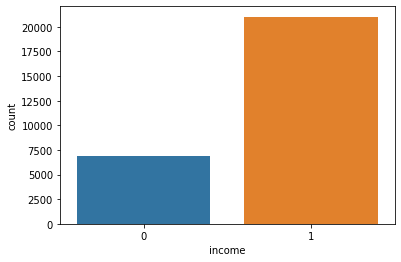

In [236]:
# 以>50k来分类，样本的分布怎样
x_ = train_data.drop('income', axis=1)
y_ = train_data.income

sns.countplot(train_data['income'], Label='count')

In [237]:
# 重采样
train_data_less = train_data[train_data.income==0]
train_data_more = train_data[train_data.income==1]

train_data.income.value_counts()

1    21024
0     6932
Name: income, dtype: int64

In [238]:
train_data_upsampled = resample(train_data_less,
                                replace=True,
                                n_samples=21024,
                                random_state=123)

# 将重采样的数据添加回去
train_data = pd.concat([train_data_more, train_data_upsampled])

In [239]:
train_data.income.value_counts()

1    21024
0    21024
Name: income, dtype: int64

In [240]:
# 把要预测的值income单独拿出来
y_train = train_data.income
x_train = train_data.drop('income', axis=1)

y_test = test_data.income
x_test = test_data.drop('income', axis=1)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(42048, 59)
(42048,)
(15060, 59)
(15060,)


In [241]:
random_forest = RandomForestClassifier(n_estimators=10000)
random_forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [242]:
y_pred = random_forest.predict(x_test)
print(accuracy_score(y_test, y_pred) * 100)

75.2788844621514


In [243]:
random_forest_confusion_matrix = confusion_matrix(y_test, y_pred)
random_forest_confusion_matrix

array([[1448, 2252],
       [1471, 9889]], dtype=int64)